## Data Prep & feature Selection for Clustering

The following part of the notebook will prepare the datasets for the clustering task.

For clustering, only a select amount of features can be relevant. Since most clustering algorithms use distance based calcualtions to determine the clusters, input features need to be of numerical values. It is also helpful for them to be ordinal and continous. This becomes evidant when looking at time data. When looking at hourly datapaints for example, an entry at hour 23:00 and 01:00 would be classified as far apart instead of close to each other. If features are not continous, they will need to be scaled in a special way, this will be adressed later. 

Let's load the dataset and look at the available features.


In [662]:
## imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
%matplotlib inline

In [663]:
# load dataset
charging_set_complete = pd.read_csv("data/cleaned_charging_set_new.csv")


In [664]:
# look at dataset again
charging_set_complete.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,requestedDeparture_year,requestedDeparture_month,requestedDeparture_day,requestedDeparture_time,requestedDeparture_weekday,connectionDuration,chargingDuration,isRegistered,fullyCharged,parkingDuration
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,...,2020,1,2,20:51:54,3,6.039167,4.378056,1,1,1.66
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,...,2020,1,2,23:31:50,3,9.025278,6.687500,1,1,2.34
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,...,2020,1,2,14:56:35,3,10.713056,2.641944,1,1,8.07
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,...,2020,1,2,15:04:58,3,2.644722,1.313056,1,1,1.33
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,...,2020,1,2,22:24:01,3,8.144167,4.291389,1,1,3.85


Feature Selection for clustering can be difficult to achieve, data scientist often rely on domain knowledge. Let's think of what we are trying to achive here: **We want to find archetypical charging events** in order to analyse the customers. What could be relevent here?
- 1. KWH delivered: this feature will be relevent because it describes the energy delivered in the charging event. People could just get a small charge to fill their battery just enough to get home, or they could do a full charge.
- 2. connectionTime: this feature will display how much time a car was connected, therefore being another indicator of different sessions types (long stay,medium stay, short stay)
- 3. hour_of_connection: Here we will explicitly look at the hour of the day. This can give us insight for possible clusters such as before work charges, after work chargers etc. This feature is in our data yet and has to be created out of features in the dataset.
- 4. parkingDuration: This feature can give us insight on the efficiency of the charging event. People could potentially charge quickly but leave their car on the spot for a while, which could be another archetypical session

In [665]:
## check dataframe for outliers

max_cD = charging_set_complete["connectionDuration"].max()
min_cD = charging_set_complete["connectionDuration"].min()

print(min_cD,max_cD)

0.0344444444444444 23.99138888888889


In [ ]:
## amount of values not satisfying the threshold for connectionDuration 

indices_CD_under = charging_set_complete[charging_set_complete["connectionDuration"]< 0.10].index.to_list()
indices_CD_over = charging_set_complete[charging_set_complete["connectionDuration"] > 72].index.to_list()
under_threshold_cD = len(indices_CD_under)
over_threshold_cD = len(indices_CD_over)

print(under_threshold_cD,over_threshold_cD)

33 0


Summing up those outlier values, we reach a total of 33 entries outside of the threshold, which is an accaptable amount to neglect, since it is less than 1% of the data entries. We can see that outliers have already been dealt with in our dataprep.

In [667]:
## remove outliers
charging_set_complete = charging_set_complete[(charging_set_complete["connectionDuration"]<72) & (charging_set_complete["connectionDuration"]>0.1)]

Create hour of connection feature in oder to include in clustering df

In [668]:
# create hour_of_connection feature
charging_set_complete["hour_of_connection"] = pd.to_datetime(charging_set_complete["connectionTime"]).dt.hour

We will now create the dataset for our clustering efforts. We include siteID and isRegistered in this dataset to analyse any differences later, but these features will not be scaled and will also not be included in the algorithm itself.

In [669]:
# create clustering dataframe
clustering_df = charging_set_complete[["kWhDelivered","connectionDuration","hour_of_connection","siteID","isRegistered","parkingDuration"]]

We will not include hour_of_day in the Standart Scaler, since these features need to be scaled differently. 

In [670]:
# scale features appropriate for Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(clustering_df[["kWhDelivered","connectionDuration","parkingDuration"]])
cluster_scaled = scaler.transform(clustering_df[["kWhDelivered","connectionDuration","parkingDuration"]])
scaled_df = pd.DataFrame(cluster_scaled, columns= ["kWhDelivered","connectionDuration","parkingDuration"], index=clustering_df.index)
scaled_df.head()

,kWhDelivered,connectionDuration,parkingDuration
0,1.304655,-0.014288,-0.294282
1,2.094581,0.809010,-0.066641
2,-0.503251,1.274345,1.851570
3,-0.910482,-0.950166,-0.404755
4,0.166735,0.566080,0.438856


In [671]:
## scale time data into cyclic encoding using the cosinus and sinus function

scaled_df['sin_connection_hour'] = np.sin(2 * np.pi * clustering_df['hour_of_connection'] / 24)
scaled_df['cos_connection_hour'] = np.cos(2 * np.pi * clustering_df['hour_of_connection'] / 24)

#scaled_df["sin_connection_day"] = np.sin(2* np.pi * clustering_df['connect_weekday'] / 7)
#scaled_df["cos_connection_day"] = np.cos(2* np.pi * clustering_df['connect_weekday'] / 7)

scaled_df.head()

,kWhDelivered,connectionDuration,parkingDuration,sin_connection_hour,cos_connection_hour
0,1.304655,-0.014288,-0.294282,-0.258819,-0.965926
1,2.094581,0.809010,-0.066641,-0.258819,-0.965926
2,-0.503251,1.274345,1.851570,-0.258819,-0.965926
3,-0.910482,-0.950166,-0.404755,-0.258819,-0.965926
4,0.166735,0.566080,0.438856,-0.500000,-0.866025


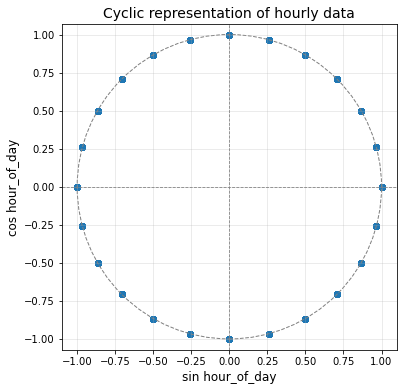

In [672]:
# plot the cyclic representation of the time data

plt.figure(figsize=(6, 6))
plt.scatter(
    scaled_df["sin_connection_hour"], scaled_df["cos_connection_hour"], alpha=0.7
)

# add a reference circle
circle = plt.Circle(
    (0, 0), 1, color="gray", fill=False, linestyle="dashed", linewidth=1
)
plt.gca().add_artist(circle)

# formatting
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.title("Cyclic representation of hourly data", fontsize=14)
plt.xlabel("sin hour_of_day", fontsize=12)
plt.ylabel("cos hour_of_day", fontsize=12)
plt.grid(alpha=0.3)
plt.axis("equal")
plt.show()

In [673]:
# print values for explainabilty
print("First row of clustering_df:")
print(clustering_df.iloc[0])

print("\nFirst row of scaled_df:")
print(scaled_df.iloc[0])

First row of clustering_df:
kWhDelivered          25.016000
connectionDuration     6.039167
hour_of_connection    13.000000
siteID                 1.000000
isRegistered           1.000000
parkingDuration        1.660000
Name: 0, dtype: float64

First row of scaled_df:
kWhDelivered           1.304655
connectionDuration    -0.014288
parkingDuration       -0.294282
sin_connection_hour   -0.258819
cos_connection_hour   -0.965926
Name: 0, dtype: float64


If we look at those values shown in the scatter plot above, we can see that sin_connection: -0.258819 and cos_connection: -0.965926 perfectly translate to the value for hour 13 in the scatterplot above.

We will refrain from doing the same scaling and including the feature for connection day, since in previous test trials adding that data has not meaningfully improved our clustering algorithm. 

In [ ]:
# check that there are no nan values, meaning scaling was successful 
scaled_df.isna().sum()

kWhDelivered           0
connectionDuration     0
parkingDuration        0
sin_connection_hour    0
cos_connection_hour    0
dtype: int64

## Clustering with kmeans


In [675]:
## create two empty arrays
clusters = []
losses = []

## set maximum valuze for amount of clusters
k_max = 30


here we prepare for the algorithm. We set k_max at 30 because we believe that that amount of clusters is very high already and we suspect the optimum tradeoff between performance and overfitting will likely be in the range of 3-10 clusters. We will however compute the loss up unitil cluster 30 just to be sure. The empty arrays will store the clusters and their respective loss for evaluation.

In [676]:
# transform df into array for better performance
scaled_array = scaled_df.values

In [677]:
scaled_array

array([[ 1.30465515, -0.01428765, -0.29428235, -0.25881905, -0.96592583],
       [ 2.09458149,  0.80900967, -0.06664122, -0.25881905, -0.96592583],
       [-0.50325073,  1.27434498,  1.85157009, -0.25881905, -0.96592583],
       ...,
       [ 0.5077885 , -0.93929091, -0.84999452, -0.70710678,  0.70710678],
       [ 0.65158031, -0.86837246, -0.84999452, -0.5       ,  0.8660254 ],
       [-0.13961678, -0.96831693, -0.59222442, -0.5       ,  0.8660254 ]])

In [678]:
# run kmeans algorithm 
for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init="auto")
    model.fit(scaled_array)
    clusters.append(k+1)
    losses.append(model.inertia_)

We will now implement something called the **"Elbow method"**. This means plotting the losses over the number of clusters to pick the right amount of clusters. Here it is important to consider a good trade-off between reducing loss while still keeping meaningful clusters. We will pick the sharpest fold of the plotted graph to indicate a good amount of clusters.

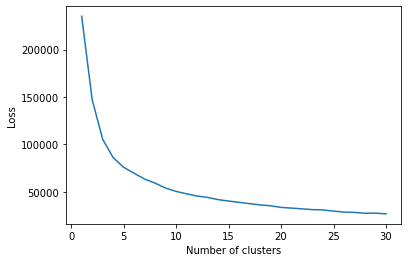

In [679]:
# plot loss in relation to cluster amount 
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0.0, 15.0)

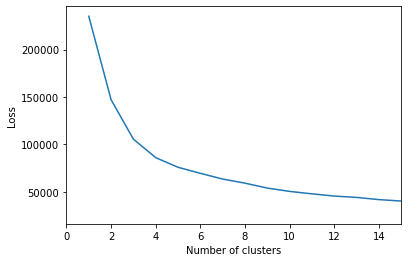

In [680]:
# zoom in 
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,15])

(0.0, 10.0)

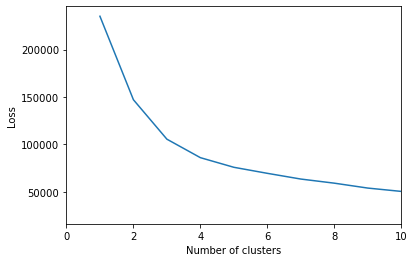

In [681]:
# zoom in again
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

Sharpest fold at 2-6, therefore and appropriate cluster amount lies in that region. Let's pick 4 clusters for now

In [682]:
# array with string representation for cluster numbers
numbers = ["zero", "one", "two","three"]

# refit algorithm
four_means = KMeans(n_clusters=4, n_init="auto")
four_means.fit(scaled_array)

# match records to clusters by calling predict
scaled_df["cluster"] = four_means.predict(scaled_array)
scaled_df["cluster"] = scaled_df["cluster"].apply(lambda x: numbers[x])

scaled_df.head()


,kWhDelivered,connectionDuration,parkingDuration,sin_connection_hour,cos_connection_hour,cluster
0,1.304655,-0.014288,-0.294282,-0.258819,-0.965926,two
1,2.094581,0.809010,-0.066641,-0.258819,-0.965926,two
2,-0.503251,1.274345,1.851570,-0.258819,-0.965926,one
3,-0.910482,-0.950166,-0.404755,-0.258819,-0.965926,three
4,0.166735,0.566080,0.438856,-0.500000,-0.866025,three


Now for explainability we will add the cluster column to the clustering dataframe that was not scaled, in order to evaluate the influences and see the actual scale of data

In [683]:
# copy cluster column onto original df
clustering_df["cluster"] = scaled_df["cluster"]

/var/folders/2p/xvrd9yr13yb4vz2jsw9pykbh0000gn/T/ipykernel_50111/229476076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df["cluster"] = scaled_df["cluster"]


In [684]:
clustering_df.head()

,kWhDelivered,connectionDuration,hour_of_connection,siteID,isRegistered,parkingDuration,cluster
0,25.016,6.039167,13,1,1,1.66,two
1,33.097,9.025278,13,1,1,2.34,two
2,6.521,10.713056,13,1,1,8.07,one
3,2.355,2.644722,13,1,1,1.33,three
4,13.375,8.144167,14,1,1,3.85,three


In [685]:
# add pallet for consistent coloring of clusters
cluster_palette = {
    "zero": "#1f77b4",  # Blue
    "one": "#ff7f0e",  # Orange
    "two": "#2ca02c",  # Green
    "three": "#d62728",  # Red
}

sns.set_palette(sns.color_palette(cluster_palette.values()))

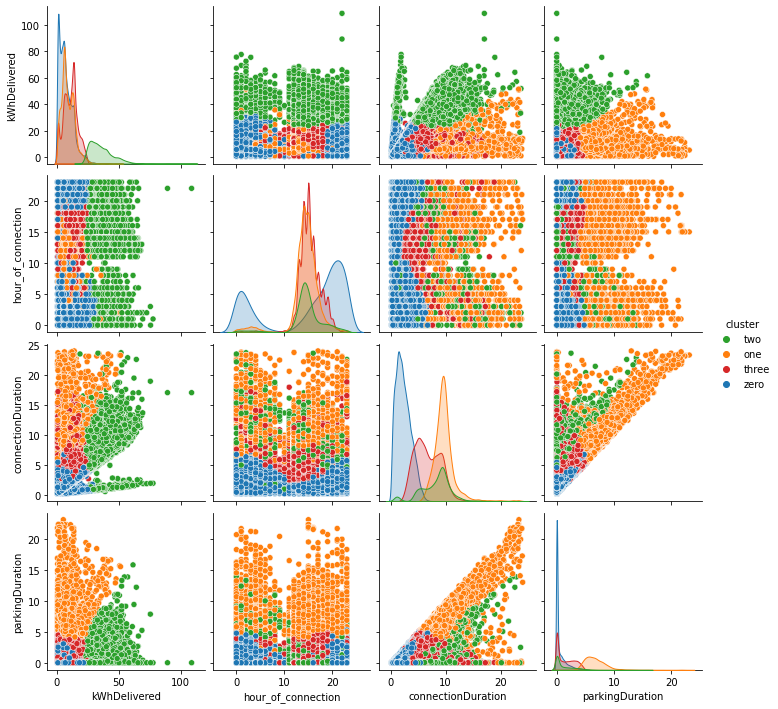

In [686]:
# plot cluster with different scatterplots
sns.pairplot(data=clustering_df[["kWhDelivered","hour_of_connection","connectionDuration","parkingDuration","cluster"]], hue="cluster",palette=cluster_palette)

Let's look at different feature relationships in more detail. We can see that there is some cluster overlap, but when looking at the clusters in more detail we will see that there is always at least one distinctive feature that seperates the clusters from each other. Technically, using soft clustering could have been another possible option, but since clusters are distinguishable (especially when looking at raw value), kmeans was sufficient.

 We will now plot different visualizations that describe the clusters in relation to different features.

**1. Scatterplot of kWhDelivered and the connectionDuration**

<AxesSubplot:xlabel='kWhDelivered', ylabel='connectionDuration'>

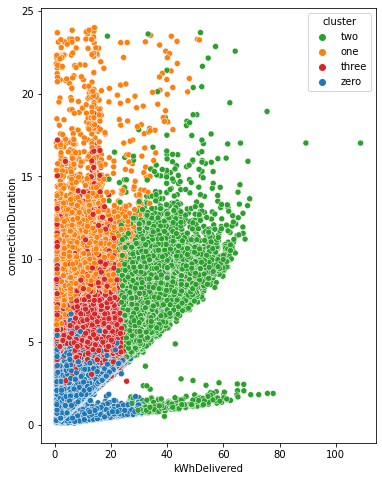

In [687]:
## plot scatterplot of the above mentiod features

plt.figure(figsize=(6,8))
sns.scatterplot(data=clustering_df, x="kWhDelivered", y="connectionDuration", hue="cluster", palette = cluster_palette)

**2. Plot a line plot of hour_of_connection and kWhDelivered**

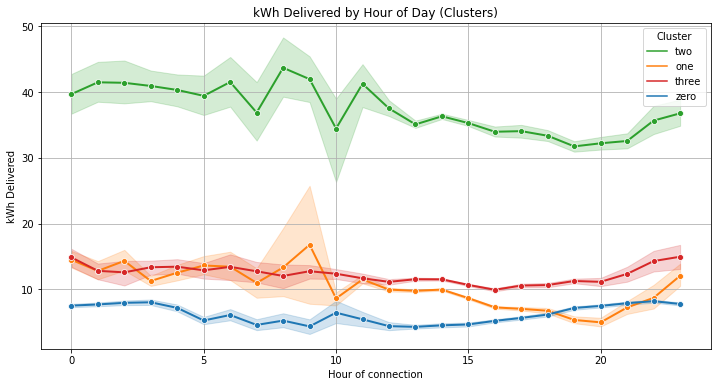

In [688]:
# line plot with hour_of_connection vs kWhDelivered
# grouped by clusters
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour_of_connection', y='kWhDelivered', hue='cluster', data=clustering_df, marker='o', lw=2, palette= cluster_palette)
plt.title('kWh Delivered by Hour of Day (Clusters)')
plt.xlabel('Hour of connection')
plt.ylabel('kWh Delivered')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


**3. Plot a line plot of connectionDuration and hour of connection**

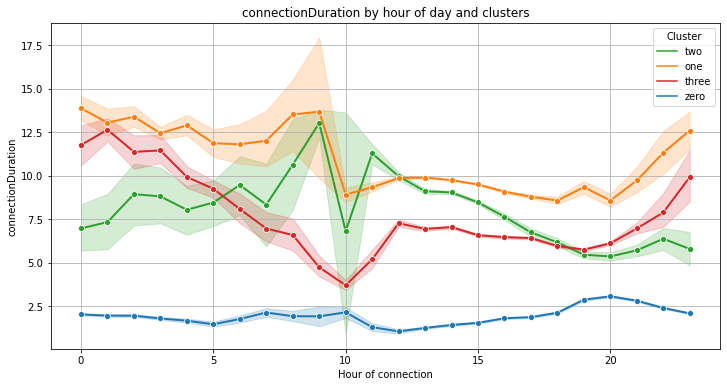

In [689]:
# line plot with hour_of_connection vs connectionDuration
# grouped by clusters
plt.figure(figsize=(12, 6))
sns.lineplot(x="hour_of_connection", y="connectionDuration", hue="cluster", data=clustering_df, marker="o", lw=2, palette=cluster_palette)
plt.title("connectionDuration by hour of day and clusters")
plt.xlabel("Hour of connection")
plt.ylabel("connectionDuration")
plt.legend(title="Cluster", loc="upper right")
plt.grid(True)
plt.show()

**4. Plot a line plot of parkingDuration and hour of connection** 

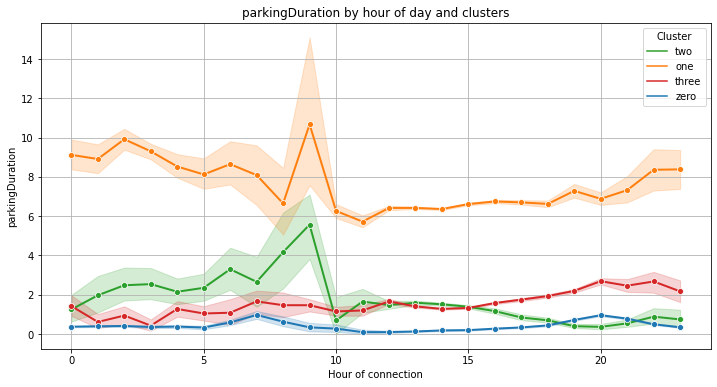

In [690]:
# line plot with hour_of_connection vs parkingDuration
# grouped by clusters
plt.figure(figsize=(12, 6))
sns.lineplot(x="hour_of_connection", y="parkingDuration", hue="cluster", data=clustering_df, marker="o", lw=2, palette=cluster_palette)
plt.title("parkingDuration by hour of day and clusters")
plt.xlabel("Hour of connection")
plt.ylabel("parkingDuration")
plt.legend(title="Cluster", loc="upper right")
plt.grid(True)
plt.show()

**5. plot kWhDelivered and hour of connection as a heatmap**

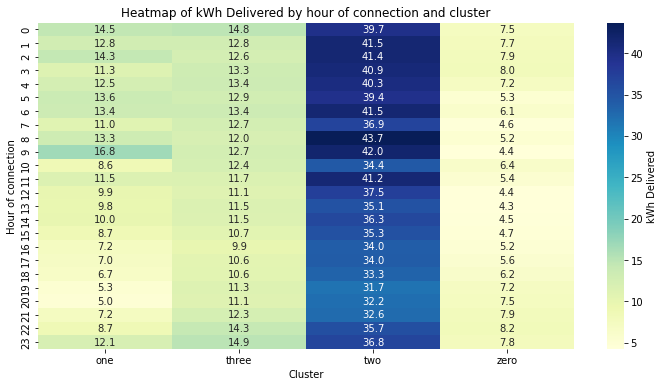

In [691]:
# pivot table to get the mean kWhDelivered per hour_of_connection per cluster
heatmap_data = clustering_df.pivot_table(values='kWhDelivered', 
                                         index='hour_of_connection', 
                                         columns='cluster', 
                                         aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.1f', cbar_kws={'label': 'kWh Delivered'})
plt.title('Heatmap of kWh Delivered by hour of connection and cluster')
plt.xlabel('Cluster')
plt.ylabel('Hour of connection')
plt.show()


**6. plot parkingDuration and hour of connection as a heatmap**

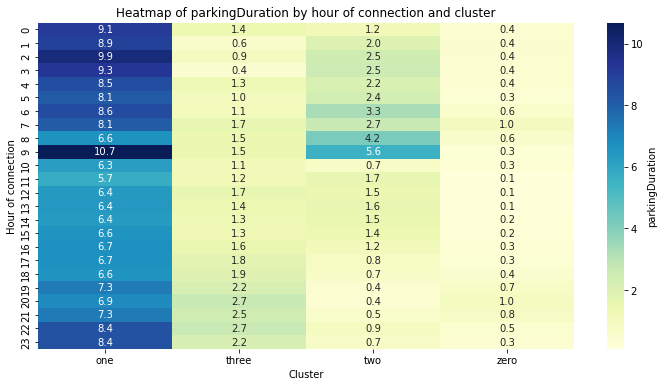

In [692]:
# Pivot table to get the mean kWhDelivered per hour_of_day per cluster
heatmap_data = clustering_df.pivot_table(values="parkingDuration", 
                                         index="hour_of_connection", 
                                         columns="cluster", 
                                         aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={"label": "parkingDuration"})
plt.title("Heatmap of parkingDuration by hour of connection and cluster")
plt.xlabel("Cluster")
plt.ylabel("Hour of connection")
plt.show()


**7. Plot connectionDuration and hour of connection as a heatmap**

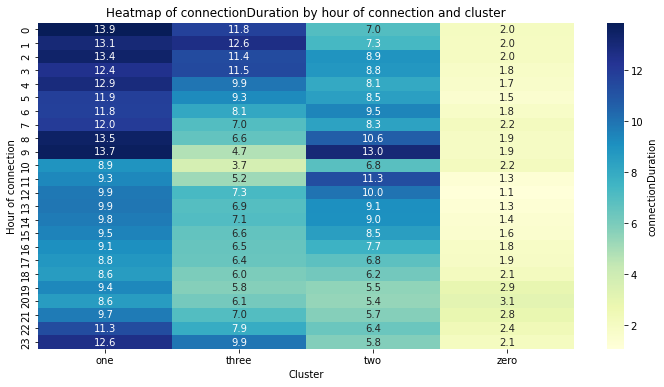

In [693]:
# Pivot table to get the mean kWhDelivered per hour_of_day per cluster
heatmap_data = clustering_df.pivot_table(values="connectionDuration", 
                                         index="hour_of_connection", 
                                         columns="cluster", 
                                         aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={"label": "connectionDuration"})
plt.title("Heatmap of connectionDuration by hour of connection and cluster")
plt.xlabel("Cluster")
plt.ylabel("Hour of connection")
plt.show()


Looking at plots 1-7 we can clearly see that clusters overlap in some areas for example cluster "zero" and "three" have similar values for KwH Delivered but vary heavily for parking Duration.

Let's take a look at the different clusters, focusing on their numbers.

**Cluster zero: Quick battery fill up:**

This cluster stands out becuase of the short connectionDuration. These people likely just quickly want to top of their battery to reach their destination. They are efficient with a small parking Duration and don't charge much energy. It is also interesting that they tend to connect later in comparison to other clusters. 50% of charging events start after 19:00, which could also indicate that these people want to do a small break because of driving late or that they just need a little more energy to get home. 


In [694]:
cluster_0 = clustering_df[clustering_df["cluster"]=="zero"]

cluster_0[["kWhDelivered","connectionDuration","hour_of_connection","parkingDuration"]].describe()

,kWhDelivered,connectionDuration,hour_of_connection,parkingDuration
count,22360.000000,22360.000000,22360.000000,22360.000000
mean,7.123697,2.261746,14.587970,0.503702
std,5.439452,1.326701,8.359292,0.891408
min,0.501000,0.100833,0.000000,0.000000
25%,2.709000,1.227222,4.000000,0.000000
50%,5.949500,2.056389,19.000000,0.000000
75%,10.442250,3.147292,21.000000,0.690000
max,31.680000,7.500278,23.000000,5.280000


**Cluster one: Park First, Charge Second:**


As the name suggests, this type of charging event has a high disperaty between the charging time and the actual time the car was connected. On average, cars stay around 10 hour, but only charge 3 of those, therefore occupying the space without actually charging for more than 2/3 of the duration. If we look at plot 6&7 we can see that during early morning and late night hour both parkingDuration and connectionDuration are highest, for cars connected at that hour. This is likely beacsue of people leaving their car parked for the day or over night. KWh Delivered has a mean of 9 and is therefore not high if we compare it with connectionDuration, which is the highest out of all clusters with the 10 hour average.


In [695]:
cluster_1 = clustering_df[clustering_df["cluster"]=="one"]

cluster_1[["kWhDelivered","connectionDuration","hour_of_connection","parkingDuration"]].describe()

,kWhDelivered,connectionDuration,hour_of_connection,parkingDuration
count,17118.000000,17118.000000,17118.000000,17118.000000
mean,8.975117,9.684500,14.249095,6.688752
std,5.399935,2.007949,3.234139,2.100388
min,0.502000,5.436111,0.000000,0.000000
25%,5.273000,8.636667,13.000000,5.300000
50%,7.899000,9.486389,15.000000,6.370000
75%,12.401750,10.291944,16.000000,7.680000
max,51.459000,23.991389,23.000000,23.110000


**Cluster Two: The high charger:**

This group focuses on maximizing battery charge. Charging events in this cluster deliver an average of 35.5 kWh, enough to fully charge smaller EV batteries or significantly replenish larger ones. Vehicles in this cluster are connected for an average of 8.2 hours, with 1.3 hours of additional parking after charging is complete.
Unlike Cluster Zero, this group balances connection time with energy delivered, indicating a clear intent to charge the battery rather than use the station as a parking spot. Charging events are evenly distributed throughout the day, reflecting varied charging needs among users.

In [696]:
cluster_2 = clustering_df[clustering_df["cluster"]=="two"]

cluster_2[["kWhDelivered","connectionDuration","hour_of_connection","parkingDuration"]].describe()

,kWhDelivered,connectionDuration,hour_of_connection,parkingDuration
count,6739.000000,6739.000000,6739.000000,6739.000000
mean,35.457400,8.215546,14.540881,1.337615
std,9.063562,2.718273,3.741370,1.771559
min,18.743168,0.506944,0.000000,0.000000
25%,28.202500,6.544306,14.000000,0.000000
50%,33.545000,8.761667,14.000000,0.470000
75%,40.183000,9.743889,16.000000,2.335000
max,108.797242,23.694444,23.000000,15.810000


**Cluster three: The moderate charger:**

This cluster builds the middleground of charging events with very moderate values throughout all features. They charge medium energy with a mean of 11 kWh delivered per charging event and they stay connected around 6.5 hours with 1.5 hours of that being pure parking time. Charging events are distributed evenly througout the day.

In [697]:
cluster_3 = clustering_df[clustering_df["cluster"]=="three"]

cluster_3[["kWhDelivered","connectionDuration","hour_of_connection","parkingDuration"]].describe()

,kWhDelivered,connectionDuration,hour_of_connection,parkingDuration
count,17334.000000,17334.000000,17334.000000,17334.000000
mean,10.945291,6.655816,15.193954,1.533708
std,5.518859,2.316444,2.464915,1.480592
min,0.507000,0.560556,0.000000,0.000000
25%,6.722250,4.804722,14.000000,0.000000
50%,11.310500,6.370139,15.000000,1.200000
75%,14.261466,8.519653,16.000000,2.820000
max,26.052000,18.812778,23.000000,5.130000


After identifying the different clusters, let's look at their amount of records. Which cluster is the most common?

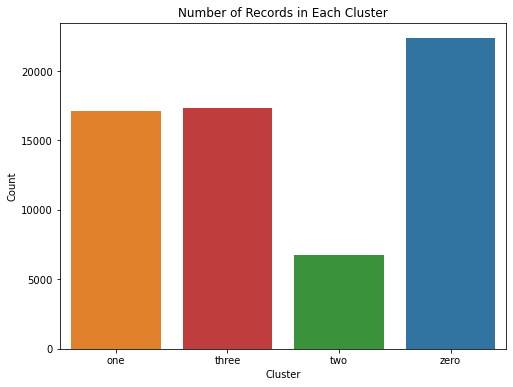

In [698]:
# count the number of occurrences for each cluster
cluster_counts = clustering_df['cluster'].value_counts().sort_index()

# bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    x=cluster_counts.index,
    y=cluster_counts.values,
    palette=[cluster_palette[c] for c in cluster_counts.index]
)
plt.title("Number of Records in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.xticks(ticks=range(len(cluster_counts.index)), labels=cluster_counts.index)
plt.show()


Here we can see that cluster zero (the quick charger) is the most common out of all clusters, with over 20000 records. Cluster three (the moderate charger) and cluster one (Park first, charge second) are almost tied at second with around 17000 entries each. Lastly, cluster two (the high charger) is the least common with around 7000 entries

Furthermore, let's also break down which cluster is more common at which site.

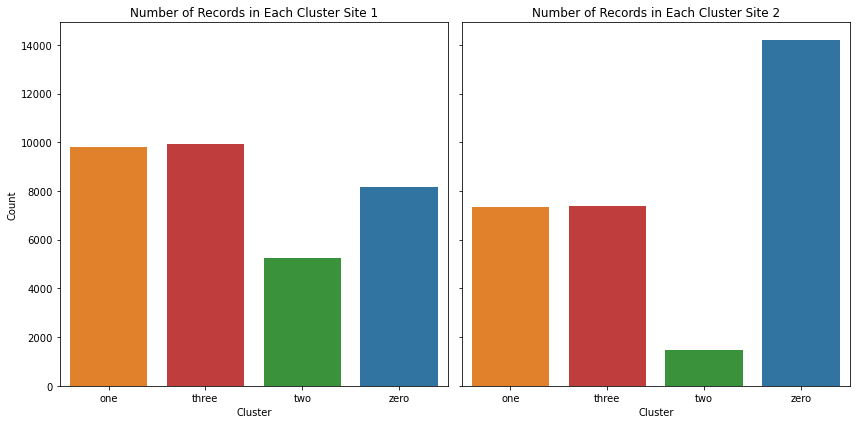

In [699]:
# filter for site 1 
filtered_df_1 = clustering_df[clustering_df["siteID"]==1]
filtered_df_2 = clustering_df[clustering_df["siteID"]==2]
# count the number of occurrences for each cluster
cluster_counts_1 = filtered_df_1['cluster'].value_counts().sort_index()
cluster_counts_2 = filtered_df_2['cluster'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# plot site 1
sns.barplot(
    ax=axes[0],
    x=cluster_counts_1.index,
    y=cluster_counts_1.values,
    palette=[cluster_palette[c] for c in cluster_counts_1.index]
)
axes[0].set_title("Number of Records in Each Cluster Site 1")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(cluster_counts_1.index)))
axes[0].set_xticklabels(cluster_counts_1.index)

# plot site 2 
sns.barplot(
    ax=axes[1],
    x=cluster_counts_2.index,
    y=cluster_counts_2.values,
    palette=[cluster_palette[c] for c in cluster_counts_2.index]
)
axes[1].set_title("Number of Records in Each Cluster Site 2")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("")
axes[1].set_xticks(range(len(cluster_counts_2.index)))
axes[1].set_xticklabels(cluster_counts_2.index)

plt.tight_layout()

# show the plots
plt.show()


We can see that for site 1, cluster three and zero are most popular, followed by cluster one and cluster two being the least popular

Site 2 is different, with cluster one clearly being the most popular. Besides that the other cluster distributing looks similar tho.

Let's also look if there are big differences between registerd and unregistered user.

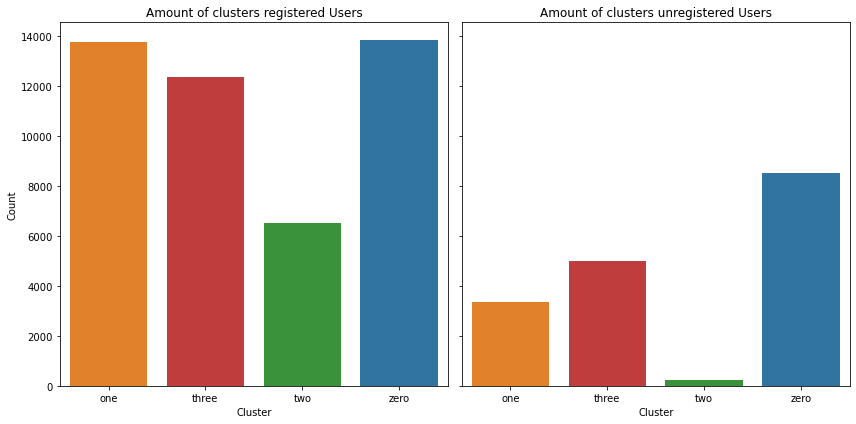

In [700]:
# filter for registered and unregistered user
filtered_df_registered = clustering_df[clustering_df["isRegistered"]==1]
filtered_df_unregistered = clustering_df[clustering_df["isRegistered"]==0]
# count the number of occurrences for each cluster
cluster_counts_registered = filtered_df_registered['cluster'].value_counts().sort_index()
cluster_counts_unregistered = filtered_df_unregistered['cluster'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# plot site 1
sns.barplot(
    ax=axes[0],
    x=cluster_counts_registered.index,
    y=cluster_counts_registered.values,
    palette=[cluster_palette[c] for c in cluster_counts_registered.index]
)
axes[0].set_title("Amount of clusters registered Users")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(cluster_counts_registered.index)))
axes[0].set_xticklabels(cluster_counts_registered.index)

# plot site 2 
sns.barplot(
    ax=axes[1],
    x=cluster_counts_unregistered.index,
    y=cluster_counts_unregistered.values,
    palette=[cluster_palette[c] for c in cluster_counts_unregistered.index]
)
axes[1].set_title("Amount of clusters unregistered Users")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("")
axes[1].set_xticks(range(len(cluster_counts_unregistered.index)))
axes[1].set_xticklabels(cluster_counts_unregistered.index)

plt.tight_layout()

# Show the plots
plt.show()

We can clearly see that registered user are more likely to be in cluster one (Park first, charge second) than unregistered. Cluster three seems to be in a similar scale for both user types but for unregistered users there seems to be barely any charging events of cluster two (the high charger), the count or cluster two in registered user is also the lowest though